# **ES413 - Classificador de Estilos Musicais**
---

Este projeto tem como objetivo desenvolver um classificador de estilos musicais utilizando técnicas de processamento de sinais e aprendizado de máquina. A ideia principal é extrair características relevantes de arquivos de áudio, como coeficientes cepstrais (MFCCs), energias em bandas de frequência e representações temporais, para treinar um modelo capaz de identificar automaticamente o estilo musical de uma música. O dataset utilizado é o GTZAN, composto por músicas de 10 gêneros diferentes.

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm

## **Aquisição de Dados**
---

In [ ]:
%%time
!wget https://www.cin.ufpe.br/~jmsf3/gtzan.zip

--2025-04-02 14:33:49--  https://www.cin.ufpe.br/~jmsf3/gtzan.zip
Resolving www.cin.ufpe.br (www.cin.ufpe.br)... 150.161.2.11
Connecting to www.cin.ufpe.br (www.cin.ufpe.br)|150.161.2.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1225869142 (1.1G) [application/zip]
Saving to: ‘gtzan.zip’

gtzan.zip           100%[===================>]   1.14G  18.8MB/s    in 65s     

2025-04-02 14:34:56 (17.9 MB/s) - ‘gtzan.zip’ saved [1225869142/1225869142]

CPU times: user 603 ms, sys: 161 ms, total: 764 ms
Wall time: 1min 6s


In [ ]:
%%capture
!unzip gtzan.zip

## **Pré-processamento**
---


### **Parâmetros de Pré-processamento**
---

In [ ]:
SAMPLE_RATE = 22050
DURATION = 30
FRAME_LENGTH = 512
HOP_LENGTH = 256
N_FFT = 2048
N_MELS = 128
N_MFCC = 20

### **Carregamento**
---

In [ ]:
def load_audio_file(file_path, duration=DURATION, sr=SAMPLE_RATE):
    try:
        audio, sr = librosa.load(file_path, sr=sr, duration=duration)
        if len(audio) < sr * duration:
            audio = np.pad(audio, (0, int(sr * duration) - len(audio)), mode='constant')
        return audio, sr
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None, None

### **Divisão em Frames com Sobreposição**
---

In [ ]:
def frame_audio(audio, frame_length=512, hop_length=256):
    # Pad audio if needed
    if len(audio) % hop_length != 0:
        padding = hop_length - (len(audio) % hop_length)
        audio = np.pad(audio, (0, padding), mode='constant')

    frames = librosa.util.frame(audio, frame_length=frame_length,
                                hop_length=hop_length)

    return frames.T

## **Seleção e Extração de Features**
---


### **1. Características Temporais**

- **Amplitude Enveloping (AE)**:
  Captura as variações globais da amplitude do sinal de áudio ao longo do tempo, representando a "forma" do áudio.

- **Signal Energy (RMS)**:  
  Representa a amplitude média do sinal, útil para identificar variações de intensidade ao longo do áudio.

- **Zero-Crossing Rate (ZCR)**:  
  Mede quantas vezes o sinal muda de polaridade (positivo para negativo ou vice-versa), indicando a percussividade do áudio.


### **2. Características Espectrais**

- **Spectral Centroid**:  
  Indica o "centro de gravidade" do espectro de frequências, relacionado ao "brilho" do som.

- **Spectral Bandwidth**:  
  Mede a dispersão das frequências ao redor do centroide, ajudando a diferenciar sons concentrados de sons mais espalhados.

- **Spectral Contrast**:
  Quantifica a diferença entre os picos e os vales no espectro de um sinal de áudio. Captura a variação de energia entre componentes harmônicos e não harmônicos.

- **Spectral Flatness**:  
  Quantifica quão "tonal" ou "ruidoso" é o sinal. Valores próximos a 1 indicam sons parecidos com ruído, enquanto valores baixos sugerem tonalidades puras.

- **Spectral Rolloff**:  
  Identifica a frequência abaixo da qual está concentrada 85% da energia do sinal, detecta a predominância de graves ou agudos.

- **Band Energy Ratio**:
  Quantifica a distribuição relativa de energia entre duas regiões de frequência de um sinal de áudio, divididas por uma frequência de corte.

### **3. MFCCs**

- **Coeficientes MFCC**:  
  Simulam a percepção humana de som usando uma escala logarítmica (Mel). Os primeiros coeficientes capturam informações gerais de energia, enquanto os demais representam detalhes espectrais mais refinados.

In [ ]:
def calculate_split_frequency_bin(split_frequency, sr, num_frequency_bins):
    frequency_range = sr / 2
    frequency_delta_per_bin = frequency_range / num_frequency_bins
    split_frequency_bin = np.floor(split_frequency / frequency_delta_per_bin)
    return int(split_frequency_bin)

In [ ]:
def band_energy_ratio(S, split_frequency, sr):
    split_frequency_bin = calculate_split_frequency_bin(split_frequency, sr, len(S[0]))
    band_energy_ratio = []

    # Calculate power spectrogram
    power_spectrogram = np.abs(S) ** 2
    power_spectrogram = power_spectrogram.T

    # Add small epsilon to avoid division by zero
    eps = np.finfo(float).eps

    for frame in power_spectrogram:
        sum_power_low = frame[:split_frequency_bin].sum()
        sum_power_high = frame[split_frequency_bin:].sum()
        total_power = sum_power_low + sum_power_high

        if total_power < eps:  # Complete silence or numerical underflow
            ber = 0.0
        else:
            ber = sum_power_low / (sum_power_high + eps)  # Add epsilon to denominator

        band_energy_ratio.append(ber)

    return np.array(band_energy_ratio)

In [ ]:
def extract_features(audio, sr=22050):
    features = {}
    frames = frame_audio(audio, FRAME_LENGTH, HOP_LENGTH)

    ae = np.array([max(frame) for frame in frames])
    features['ae_mean'] = np.mean(ae)
    features['ae_var'] = np.var(ae)

    rms = librosa.feature.rms(y=audio, hop_length=HOP_LENGTH)
    features['rms_mean'] = np.mean(rms)
    features['rms_var'] = np.var(rms)

    zcr = librosa.feature.zero_crossing_rate(audio, hop_length=HOP_LENGTH)
    features['zcr_mean'] = np.mean(zcr)
    features['zcr_var'] = np.var(zcr)

    stft = np.abs(librosa.stft(audio, n_fft=N_FFT, hop_length=HOP_LENGTH))
    spectral_centroid = librosa.feature.spectral_centroid(S=stft, sr=sr)
    features['spectral_centroid_mean'] = np.mean(spectral_centroid)
    features['spectral_centroid_var'] = np.var(spectral_centroid)

    spectral_bandwidth = librosa.feature.spectral_bandwidth(S=stft, sr=sr)
    features['spectral_bandwidth_mean'] = np.mean(spectral_bandwidth)
    features['spectral_bandwidth_var'] = np.var(spectral_bandwidth)

    spectral_contrast = librosa.feature.spectral_contrast(S=stft, sr=sr)
    features['spectral_contrast_mean'] = np.mean(spectral_contrast)
    features['spectral_contrast_var'] = np.var(spectral_contrast)

    spectral_flatness = librosa.feature.spectral_flatness(S=stft)
    features['spectral_flatness_mean'] = np.mean(spectral_flatness)
    features['spectral_flatness_var'] = np.var(spectral_flatness)

    spectral_rolloff = librosa.feature.spectral_rolloff(S=stft, sr=sr)
    features['spectral_rolloff_mean'] = np.mean(spectral_rolloff)
    features['spectral_rolloff_var'] = np.var(spectral_rolloff)

    stft = librosa.stft(audio, n_fft=N_FFT, hop_length=HOP_LENGTH)
    ber = band_energy_ratio(S=stft, split_frequency=1000, sr=sr)
    features['ber_ratio_mean'] = np.mean(ber)
    features['ber_ratio_var'] = np.var(ber)

    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=N_MFCC, hop_length=HOP_LENGTH)

    for i in range(N_MFCC):
        features[f'mfcc_{i}_mean'] = np.mean(mfccs[i])
        features[f'mfcc_{i}_var'] = np.var(mfccs[i])

    return features

In [ ]:
def generate_dataset(data_dir, genres):
    data = []

    for genre in genres:
        genre_dir = os.path.join(data_dir, genre)

        if not os.path.exists(genre_dir):
            print(f"Directory not found: {genre_dir}")
            continue

        files = [file for file in os.listdir(genre_dir) if file.endswith('.wav')]

        for i, file in tqdm(enumerate(files), desc=genre):
            file_path = os.path.join(genre_dir, file)

            audio, sr = load_audio_file(file_path, duration=DURATION, sr=SAMPLE_RATE)

            if audio is None:
                print(f"Failed loading {file_path}")
                continue

            if audio is None:
                print(f"Failed decimating {file_path}")
                continue

            try:
                features = extract_features(audio, sr=sr)
                features['genre'] = genre
                data.append(features)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
                continue

    df = pd.DataFrame(data)
    return df

## **Classificação**
---

O processo de classificação inicia com a separação do nosso conjunto em dados de treino (80%) e teste (20%), garantindo que o modelo será avaliado em amostras nunca vistas durante o treinamento.

Para a classificação propriamente dita, utilizamos diferentes modelos como Regressão Logística, Random Forest, SVM, KNN e Gradient Boosting.

A avaliação dos modelos foi feita através de métricas como a matriz de confusão, que nos mostra exatamente onde ocorrem os acertos e erros do classificador, permitindo identificar quais gêneros são mais facilmente confundidos entre si. Além disso, usamos o *classification report* para fornecer medidas de precisão, *recall* e *f1-score* para cada classe individualmente, dando uma visão detalhada do desempenho por gênero musical.

In [ ]:
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal',
          'pop', 'reggae', 'rock']

data_dir = 'gtzan'
gtzan = generate_dataset(data_dir, genres)

X = gtzan.drop(columns=['genre'])
y = gtzan['genre']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

blues: 100it [01:13,  1.37it/s]
classical: 100it [01:11,  1.40it/s]
country: 100it [01:10,  1.41it/s]
disco: 100it [01:09,  1.44it/s]
hiphop: 100it [01:11,  1.41it/s]
jazz: 46it [00:31,  1.45it/s]<ipython-input-16-ed73f3e4df16>:3: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=sr, duration=duration)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
jazz: 47it [00:32,  1.74it/s]

Error loading gtzan/jazz/jazz.00054.wav: 
Failed loading gtzan/jazz/jazz.00054.wav


jazz: 100it [01:09,  1.44it/s]
metal: 100it [01:10,  1.43it/s]
pop: 100it [01:09,  1.45it/s]
reggae: 100it [01:09,  1.44it/s]
rock: 100it [01:09,  1.43it/s]



Logistic Regression:

              precision    recall  f1-score   support

       blues       0.73      0.80      0.76        20
   classical       0.94      0.80      0.86        20
     country       0.64      0.70      0.67        20
       disco       0.60      0.60      0.60        20
      hiphop       0.53      0.50      0.51        20
        jazz       0.71      0.75      0.73        20
       metal       0.82      0.90      0.86        20
         pop       0.70      0.70      0.70        20
      reggae       0.60      0.60      0.60        20
        rock       0.59      0.50      0.54        20

    accuracy                           0.69       200
   macro avg       0.69      0.68      0.68       200
weighted avg       0.69      0.69      0.68       200
 



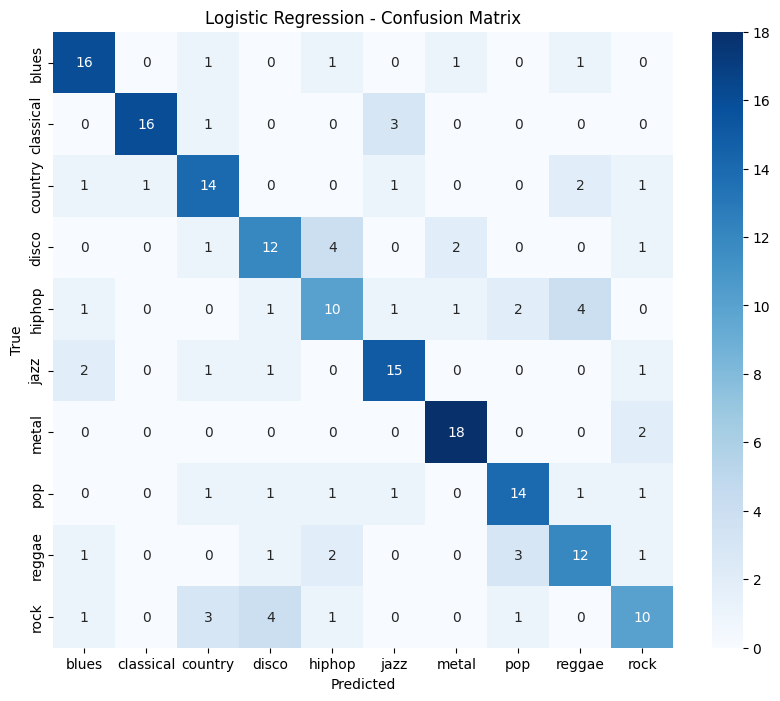


Random Forest:

              precision    recall  f1-score   support

       blues       0.71      0.75      0.73        20
   classical       0.88      0.75      0.81        20
     country       0.62      0.65      0.63        20
       disco       0.58      0.55      0.56        20
      hiphop       0.58      0.75      0.65        20
        jazz       0.67      0.80      0.73        20
       metal       1.00      0.90      0.95        20
         pop       0.82      0.70      0.76        20
      reggae       0.61      0.55      0.58        20
        rock       0.58      0.55      0.56        20

    accuracy                           0.69       200
   macro avg       0.71      0.70      0.70       200
weighted avg       0.71      0.69      0.70       200
 



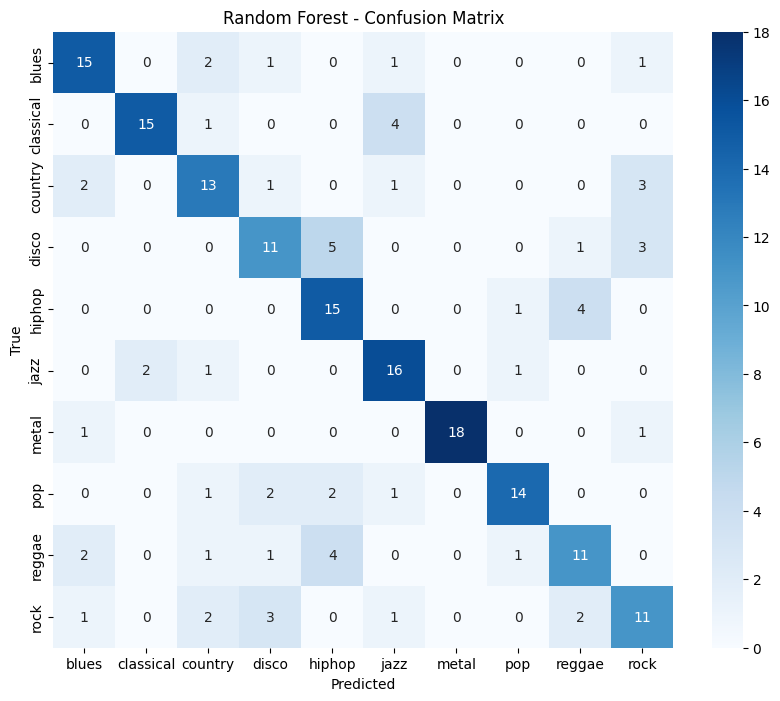


SVM:

              precision    recall  f1-score   support

       blues       0.95      0.95      0.95        20
   classical       0.84      0.80      0.82        20
     country       0.76      0.80      0.78        20
       disco       0.74      0.70      0.72        20
      hiphop       0.61      0.70      0.65        20
        jazz       0.82      0.90      0.86        20
       metal       0.89      0.85      0.87        20
         pop       0.78      0.70      0.74        20
      reggae       0.70      0.70      0.70        20
        rock       0.74      0.70      0.72        20

    accuracy                           0.78       200
   macro avg       0.78      0.78      0.78       200
weighted avg       0.78      0.78      0.78       200
 



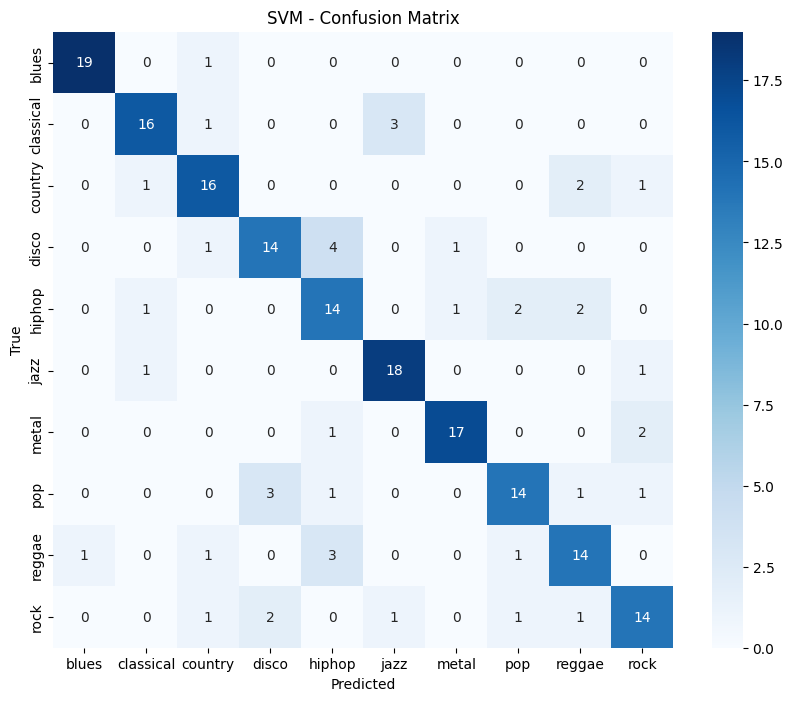


KNN:

              precision    recall  f1-score   support

       blues       0.78      0.90      0.84        20
   classical       0.71      0.75      0.73        20
     country       0.58      0.75      0.65        20
       disco       0.52      0.55      0.54        20
      hiphop       0.67      0.80      0.73        20
        jazz       0.70      0.70      0.70        20
       metal       0.94      0.80      0.86        20
         pop       0.83      0.75      0.79        20
      reggae       0.65      0.55      0.59        20
        rock       0.46      0.30      0.36        20

    accuracy                           0.69       200
   macro avg       0.68      0.68      0.68       200
weighted avg       0.68      0.69      0.68       200
 



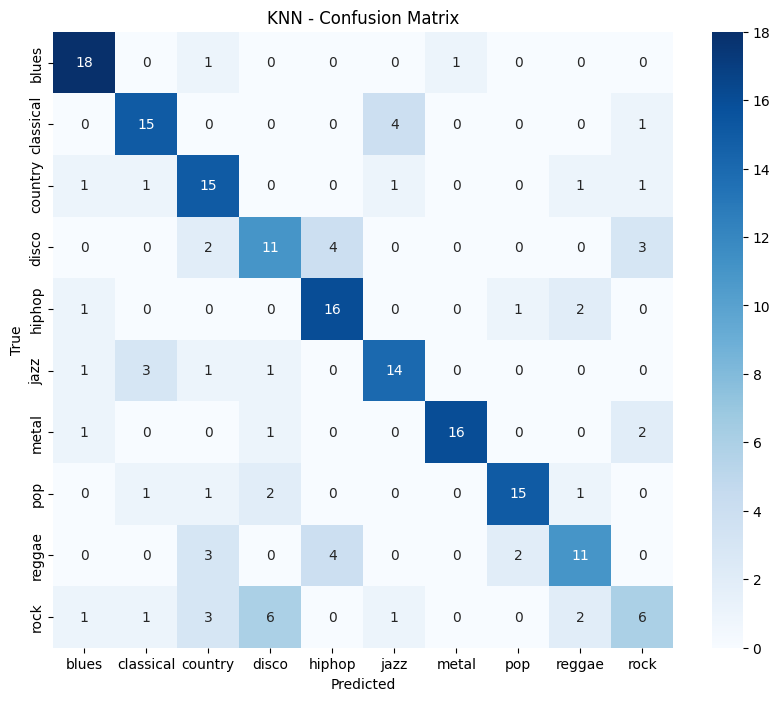


Gradient Boosting:

              precision    recall  f1-score   support

       blues       0.61      0.70      0.65        20
   classical       0.78      0.70      0.74        20
     country       0.70      0.80      0.74        20
       disco       0.50      0.60      0.55        20
      hiphop       0.62      0.65      0.63        20
        jazz       0.72      0.65      0.68        20
       metal       1.00      0.80      0.89        20
         pop       0.80      0.80      0.80        20
      reggae       0.68      0.65      0.67        20
        rock       0.50      0.45      0.47        20

    accuracy                           0.68       200
   macro avg       0.69      0.68      0.68       200
weighted avg       0.69      0.68      0.68       200
 



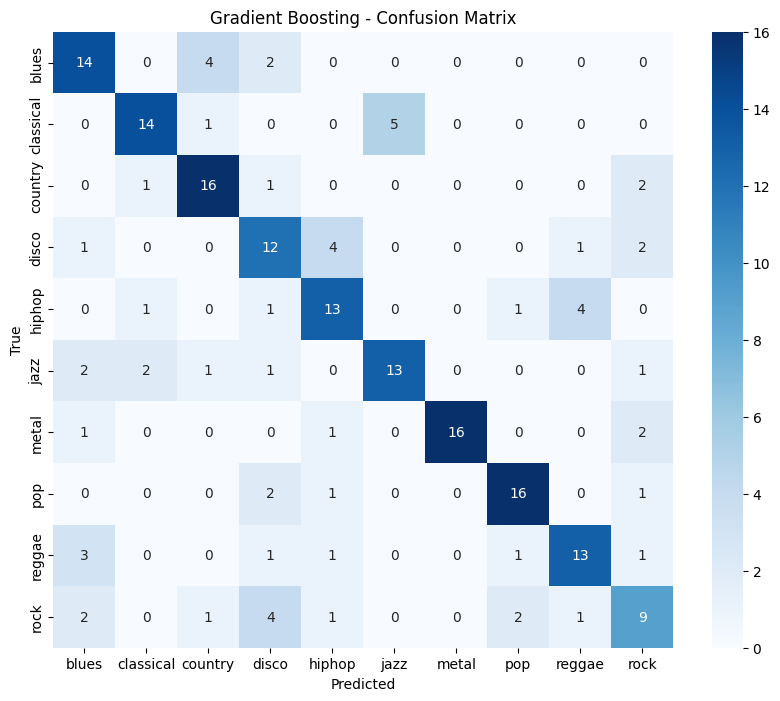

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=500, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', C=10, gamma=0.01, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n{name}:\n")
    print(classification_report(y_test, y_pred, target_names=genres), '\n')

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=genres, yticklabels=genres)

    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.show()

In [ ]:
from scipy.io import wavfile

audio, sr = load_audio_file('gtzan/blues/blues.00000.wav')
original_genre = 'blues'

noisy_audio = audio + 0.05 * np.random.normal(0, 1, len(audio))
wavfile.write('noisy_blues.00000.wav', sr, noisy_audio)
noisy_features = extract_features(noisy_audio, sr=sr)
noisy = pd.DataFrame([noisy_features])

echo_audio = np.copy(audio)
echo_audio[int(1.0 * sr):] += 0.7 * audio[:-int(1.0 * sr)]
wavfile.write('echo_blues.00000.wav', sr, echo_audio)
echo_features = extract_features(echo_audio, sr=sr)
echo = pd.DataFrame([echo_features])

for name, model in models.items():
    print(f"\n{name}:")

    pred_genre_noisy = model.predict(scaler.transform(noisy))[0]
    print(f"Noisy - Original: {original_genre}, Predicted: {pred_genre_noisy}")

    pred_genre_echo = model.predict(scaler.transform(echo))[0]
    print(f"Echo - Original: {original_genre}, Predicted: {pred_genre_echo}")


Logistic Regression:
Noisy - Original: blues, Predicted: disco
Echo - Original: blues, Predicted: blues

Random Forest:
Noisy - Original: blues, Predicted: rock
Echo - Original: blues, Predicted: blues

SVM:
Noisy - Original: blues, Predicted: rock
Echo - Original: blues, Predicted: rock

KNN:
Noisy - Original: blues, Predicted: disco
Echo - Original: blues, Predicted: rock

Gradient Boosting:
Noisy - Original: blues, Predicted: rock
Echo - Original: blues, Predicted: blues
